In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lmfit import Minimizer, Parameters
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")

## Load Data

In [2]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/Effect_RBP_binding_THOR"
os.chdir(folder)

color_1x = "#6D89AD"
color_1xdel = "#B5C2F7"
color_2x = "#0F183D"
color_2xdel = "#245696"

df_1x = pd.read_csv("colocalization_AIO_concat-THOR_1x_100ms.csv")
df_1xdel = pd.read_csv("colocalization_AIO_concat-THORdel_1x_100ms.csv")
df_2x = pd.read_csv("colocalization_AIO_concat-THOR_2x_100ms.csv")
df_2xdel = pd.read_csv("colocalization_AIO_concat-THORdel_2x_100ms.csv")

## Functions

In [3]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)


# def get_dwell_times_split(array_in_condensate, array_trackID, array_R_nm):
#     threshold_PB_HOPS = 350  # nm
#     # Find the indices where the array changes from False to True or vice versa
#     change_indices_condensate = (
#         np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
#     )

#     # Find the indices where the trackID changes
#     change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

#     # Combine the change indices from both arrays
#     change_indices = np.unique(
#         np.concatenate((change_indices_condensate, change_indices_trackID))
#     )

#     # Add the start and end indices to the change_indices array
#     change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

#     # Calculate the durations of each True event
#     dwell_times_PB = []
#     dwell_times_HOPS = []
#     for i in range(len(change_indices) - 1):
#         if array_in_condensate[change_indices[i]]:
#             average_r = np.mean(array_R_nm[change_indices[i] : change_indices[i + 1]])
#             if average_r >= threshold_PB_HOPS:
#                 dwell_times_PB.append(change_indices[i + 1] - change_indices[i])
#             else:
#                 dwell_times_HOPS.append(change_indices[i + 1] - change_indices[i])

#     return np.array(dwell_times_PB), np.array(dwell_times_HOPS)


def calc_R2(ydata, yfit):
    # residual sum of squares (ss_tot)
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    # r_squared-value
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


def cdf_lmfit_dual(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    a2 = params["a2"]
    tau1 = params["tau1"]
    tau2 = params["tau2"]
    model = 1 - a1 * np.exp(-t / tau1) - a2 * np.exp(-t / tau2)
    return model - data


def cdf_lmfit_single(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    # a1 = params["a1"]
    tau1 = params["tau1"]
    model = 1 - np.exp(-t / tau1)
    return model - data


def fit_CDF_dual(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0)
    params.add("a2", expr="1-a1")
    params.add("tau1", min=0.03, max=0.5, value=0.1)  # min=ln2/0.1
    params.add("tau2", min=0.5, max=2, value=1)

    # do fit, with the default leastsq algorithm
    minner = Minimizer(cdf_lmfit_dual, params, fcn_args=(bin_centers, cumulative_hist))
    result = minner.minimize()

    a1 = result.params["a1"].value
    a2 = result.params["a2"].value
    tau1 = result.params["tau1"].value
    tau2 = result.params["tau2"].value
    a1_se = result.params["a1"].stderr
    a2_se = result.params["a2"].stderr
    tau1_se = result.params["tau1"].stderr
    tau2_se = result.params["tau2"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    print("a1", a1, a1_se)
    print("tau1", tau1, tau1_se)
    print("a2", a2, a2_se)
    print("tau2", tau2, tau2_se)
    print("R2", R2)

    return {
        "a1": a1,
        "a2": a2,
        "tau1": tau1,
        "tau2": tau2,
        "a1_se": a1_se,
        "a2_se": a2_se,
        "tau1_se": tau1_se,
        "tau2_se": tau2_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def fit_CDF_single(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    # params.add("a1", min=0, max=1, value=0.8)
    params.add("tau1", min=0.03, max=2, value=1)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(
        cdf_lmfit_single, params, fcn_args=(bin_centers, cumulative_hist)
    )
    result = minner.minimize()

    # a1 = result.params["a1"].value
    tau1 = result.params["tau1"].value
    # a1_se = result.params["a1"].stderr
    tau1_se = result.params["tau1"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    # print("a1", a1, a1_se)
    print("tau", tau1, tau1_se)
    print("R2", R2)

    return {
        # "a1": a1,
        "tau": tau1,
        # "a1_se": a1_se,
        "tau_se": tau1_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def count_dwell_events(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )
    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )
    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
    # Calculate the durations of each trajectory, and then all dwell events within
    N_dwell_per_track = []
    for i in range(len(change_indices_trackID) - 1):
        bool_change_indices_condensate_within_track = (
            change_indices_condensate >= change_indices_trackID[i]
        ) & (change_indices_condensate <= change_indices_trackID[i + 1])
        N_dwell_per_track.append(np.sum(bool_change_indices_condensate_within_track))

    return np.array(N_dwell_per_track)


# def count_dwell_events_split(array_in_condensate, array_trackID, array_R_nm):
#     threshold_PB_HOPS = 350  # nm
#     # Find the indices where the array changes from False to True or vice versa
#     change_indices_condensate = (
#         np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
#     )
#     # Find the indices where the trackID changes
#     change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
#     # Combine the change indices from both arrays
#     change_indices = np.unique(
#         np.concatenate((change_indices_condensate, change_indices_trackID))
#     )
#     # Add the start and end indices to the change_indices array
#     change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
#     # Calculate the durations of each trajectory, and then all dwell events within
#     N_dwell_per_track_PB = []
#     N_dwell_per_track_HOPS = []
#     for i in range(len(change_indices_trackID) - 1):
#         average_r = np.mean(
#             array_R_nm[change_indices_trackID[i] : change_indices_trackID[i + 1]]
#         )
#         bool_change_indices_condensate_within_track = (
#             change_indices_condensate >= change_indices_trackID[i]
#         ) & (change_indices_condensate <= change_indices_trackID[i + 1])
#         N_dwell_per_track = np.sum(bool_change_indices_condensate_within_track)

#         if average_r >= threshold_PB_HOPS:
#             N_dwell_per_track_PB.append(N_dwell_per_track)
#         else:
#             N_dwell_per_track_HOPS.append(N_dwell_per_track)

#     return (
#         np.array(N_dwell_per_track_PB),
#         np.array(N_dwell_per_track_HOPS),
#     )

## Interaction (Dwell) Time Calculate

In [4]:
dwell_times_1x = (
    get_dwell_times(df_1x["InCondensate"].to_numpy(), df_1x["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
dwell_times_1xdel = (
    get_dwell_times(df_1xdel["InCondensate"].to_numpy(), df_1xdel["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
dwell_times_2x = (
    get_dwell_times(df_2x["InCondensate"].to_numpy(), df_2x["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
dwell_times_2xdel = (
    get_dwell_times(df_2xdel["InCondensate"].to_numpy(), df_2xdel["RNA_trackID"].to_numpy())
    * 0.1
)  # unit s
data = pd.concat(
    [
        pd.DataFrame({"dwell_time": dwell_times_1x, "label": "iso"}),
        pd.DataFrame({"dwell_time": dwell_times_1xdel, "label": "iso, $\Delta$"}),
        pd.DataFrame({"dwell_time": dwell_times_2x, "label": "hyper"}),
        pd.DataFrame({"dwell_time": dwell_times_2xdel, "label": "hyper, $\Delta$"}),
    ],
    ignore_index=True,
)

In [5]:
print("iso")
results_2exp_1x = fit_CDF_dual(dwell_times_1x)
results_1exp_1x = fit_CDF_single(dwell_times_1x)
print("iso, del")
results_2exp_1xdel = fit_CDF_dual(dwell_times_1xdel)
results_1exp_1xdel = fit_CDF_single(dwell_times_1xdel)
print('hyper')
results_2exp_2x = fit_CDF_dual(dwell_times_2x)
results_1exp_2x = fit_CDF_single(dwell_times_2x)
print('hyper, del')
results_2exp_2xdel = fit_CDF_dual(dwell_times_2xdel)
results_1exp_2xdel = fit_CDF_single(dwell_times_2xdel)

iso
a1 0.47281423245253873 0.015258246474479754
tau1 0.09424241782897524 0.0066564740345819665
a2 0.5271857675474613 0.015258246463457175
tau2 0.6802903710018724 0.016487944844942835
R2 0.99041377396525
tau 0.36206433370742697 0.010133709328004933
R2 0.8520241358471975
iso, del
a1 0.5815308317485185 0.01723836247774504
tau1 0.11210335491127216 0.006472931029224116
a2 0.4184691682514815 0.017238362477913684
tau2 0.7687566825155254 0.027507597162584378
R2 0.9858255677524412
tau 0.3260120361171467 0.010431198980932145
R2 0.792697280934437
hyper
a1 0.7292154034153688 0.042000339344858445
tau1 0.13174986962474325 0.0077282496871444095
a2 0.27078459658463117 0.04200033927232965
tau2 0.6518268797895725 0.05473537808709787
R2 0.9845760273318809
tau 0.23066777538594227 0.0054273850720246925
R2 0.890292092146416
hyper, del
a1 0.7769460637954324 0.029154863030942516
tau1 0.13399174370355238 0.005578881823352675
a2 0.2230539362045676 0.029154863041799827
tau2 0.6745652541849892 0.04959268323757434

## Fit to CDF, 1x, 2x, individually, no split

In [6]:
lst_dwell_times = [
    dwell_times_1x,
    dwell_times_1xdel,
    dwell_times_2x,
    dwell_times_2xdel,
]
lst_results_single = [
    results_1exp_1x,
    results_1exp_1xdel,
    results_1exp_2x,
    results_1exp_2xdel,
]
lst_results_dual = [
    results_2exp_1x,
    results_2exp_1xdel,
    results_2exp_2x,
    results_2exp_2xdel,
]
lst_color = [color_1x, color_1xdel, color_2x, color_2xdel]
lst_title = [
    "isotonic, THOR",
    "isotonic, THOR$\Delta$",
    "hypertonic, THOR",
    "hypertonic, THOR$\Delta$",
]
lst_fname_save = [
    "THOR_1x",
    "THORdel_1x",
    "THOR_2x",
    "THORdel_2x",
]

for dwell_times, results_single, results_dual, color, title, fname_save in zip(
    lst_dwell_times,
    lst_results_single,
    lst_results_dual,
    lst_color,
    lst_title,
    lst_fname_save,
):
    plt.figure(figsize=(4, 3))
    ax = sns.histplot(
        data=dwell_times,
        color="gray",
        bins=100,
        binrange=(0.1, 3),
        stat="probability",
        common_norm=False,
        lw=2,
        element="step",
        fill=False,
        cumulative=True,
    )
    # plot single fit
    plt.plot(
        results_single["bin_centers"],
        results_single["yfit"],
        color=color,
        linestyle="--",
        label="1-exp",
        lw=1,
    )
    # plot dual fit
    plt.plot(
        results_dual["bin_centers"],
        results_dual["yfit"],
        color=color,
        linestyle="-",
        label="2-exp",
        lw=1,
    )
    # add text
    left = 1.1
    top = 0.8
    gap = 0.075
    plt.text(
        left,
        top,
        "1-exp R$^2$ = " + "{:.3f}".format(round(results_single["R2"], 3)),
        fontsize=17,
        color=color,
        horizontalalignment="left",
    )
    plt.text(
        left,
        top - gap * 1,
        "2-exp R$^2$ = " + "{:.3f}".format(round(results_dual["R2"], 3)),
        fontsize=17,
        color=color,
        horizontalalignment="left",
    )
    # adjust other param
    plt.legend(frameon=False, loc=4, fontsize=18)
    plt.xlim(0.1, 3)
    plt.ylim(0.5, 1.02)
    plt.xlabel("Dwell time, s", fontsize=18)
    plt.ylabel("CDF", fontsize=18)
    plt.title(title, fontsize=18)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)
    plt.gca().tick_params(axis="both", which="major", labelsize=18)
    plt.savefig(
        "compare_exp_fits-" + fname_save + ".png",
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()

## barplot A, tau, R2

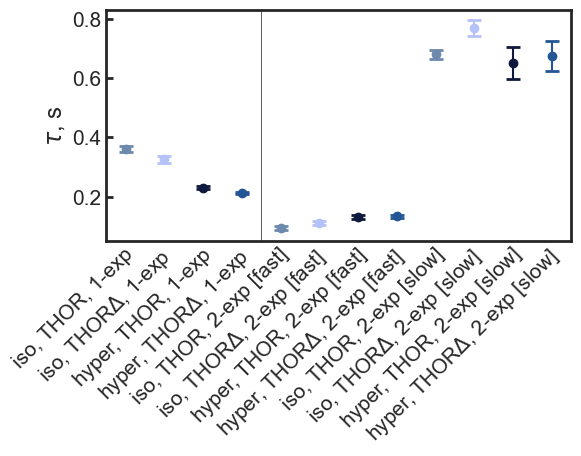

In [7]:
conditions_ordered = [
    "iso, THOR, 1-exp",
    "iso, THOR$\Delta$, 1-exp",
    "hyper, THOR, 1-exp",
    "hyper, THOR$\Delta$, 1-exp",
    "iso, THOR, 2-exp [fast]",
    "iso, THOR$\Delta$, 2-exp [fast]",
    "hyper, THOR, 2-exp [fast]",
    "hyper, THOR$\Delta$, 2-exp [fast]",
    "iso, THOR, 2-exp [slow]",
    "iso, THOR$\Delta$, 2-exp [slow]",
    "hyper, THOR, 2-exp [slow]",
    "hyper, THOR$\Delta$, 2-exp [slow]",
]
lst_tau = [
    results_1exp_1x["tau"],
    results_1exp_1xdel["tau"],
    results_1exp_2x["tau"],
    results_1exp_2xdel["tau"],
    results_2exp_1x["tau1"],
    results_2exp_1xdel["tau1"],
    results_2exp_2x["tau1"],
    results_2exp_2xdel["tau1"],
    results_2exp_1x["tau2"],
    results_2exp_1xdel["tau2"],
    results_2exp_2x["tau2"],
    results_2exp_2xdel["tau2"],
]
lst_tau_se = [
    results_1exp_1x["tau_se"],
    results_1exp_1xdel["tau_se"],
    results_1exp_2x["tau_se"],
    results_1exp_2xdel["tau_se"],
    results_2exp_1x["tau1_se"],
    results_2exp_1xdel["tau1_se"],
    results_2exp_2x["tau1_se"],
    results_2exp_2xdel["tau1_se"],
    results_2exp_1x["tau2_se"],
    results_2exp_1xdel["tau2_se"],
    results_2exp_2x["tau2_se"],
    results_2exp_2xdel["tau2_se"],
]
colors = [
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
]

plt.figure(figsize=(6, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[3] + x_pos[4]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_tau[i],
        yerr=lst_tau_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel(r"$\tau$, s", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.savefig(
    "doterrorplot_tau.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

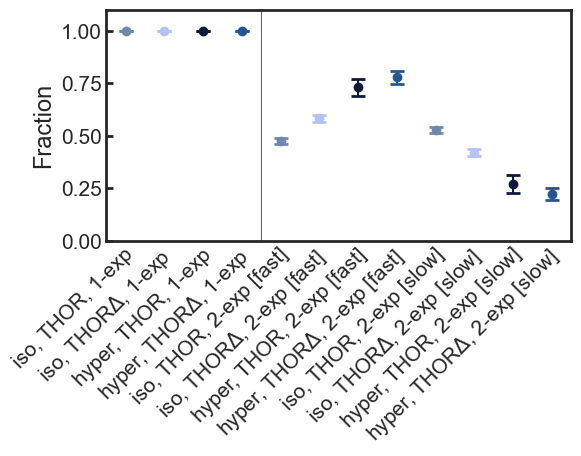

In [8]:
conditions_ordered = [
    "iso, THOR, 1-exp",
    "iso, THOR$\Delta$, 1-exp",
    "hyper, THOR, 1-exp",
    "hyper, THOR$\Delta$, 1-exp",
    "iso, THOR, 2-exp [fast]",
    "iso, THOR$\Delta$, 2-exp [fast]",
    "hyper, THOR, 2-exp [fast]",
    "hyper, THOR$\Delta$, 2-exp [fast]",
    "iso, THOR, 2-exp [slow]",
    "iso, THOR$\Delta$, 2-exp [slow]",
    "hyper, THOR, 2-exp [slow]",
    "hyper, THOR$\Delta$, 2-exp [slow]",
]
lst_frac = [
    1,
    1,
    1,
    1,
    results_2exp_1x["a1"],
    results_2exp_1xdel["a1"],
    results_2exp_2x["a1"],
    results_2exp_2xdel["a1"],
    results_2exp_1x["a2"],
    results_2exp_1xdel["a2"],
    results_2exp_2x["a2"],
    results_2exp_2xdel["a2"],
]
lst_frac_se = [
    0,
    0,
    0,
    0,
    results_2exp_1x["a1_se"],
    results_2exp_1xdel["a1_se"],
    results_2exp_2x["a1_se"],
    results_2exp_2xdel["a1_se"],
    results_2exp_1x["a2_se"],
    results_2exp_1xdel["a2_se"],
    results_2exp_2x["a2_se"],
    results_2exp_2xdel["a2_se"],
]
colors = [
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
    color_1x,
    color_1xdel,
    color_2x,
    color_2xdel,
]

plt.figure(figsize=(6, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[3] + x_pos[4]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_frac[i],
        yerr=lst_frac_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel("Fraction", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.ylim(0, 1.1)
plt.savefig(
    "doterrorplot_frac.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

# Interaction frequency

In [9]:
N_dwell_per_track_1x = count_dwell_events(
    df_1x["InCondensate"].to_numpy(),
    df_1x["RNA_trackID"].to_numpy(),
)
N_dwell_per_track_1xdel = count_dwell_events(
    df_1xdel["InCondensate"].to_numpy(),
    df_1xdel["RNA_trackID"].to_numpy(),
)
N_dwell_per_track_2x = count_dwell_events(
    df_2x["InCondensate"].to_numpy(),
    df_2x["RNA_trackID"].to_numpy(),
)
N_dwell_per_track_2xdel = count_dwell_events(
    df_2xdel["InCondensate"].to_numpy(),
    df_2xdel["RNA_trackID"].to_numpy(),
)

In [10]:
def bootstrap_frac(arr):
    arr = arr[arr > 0] # first remove all tracks with no dwell events
    n = round(len(arr) * 0.3)
    f1_samples = []
    f2_samples = []
    f3_samples = []

    for _ in range(1000):
        bootstrap_sample = np.random.choice(arr, size=n, replace=True)
        f1 = np.sum(bootstrap_sample == 1) / n
        f2 = np.sum((bootstrap_sample > 1) & (bootstrap_sample <= 3)) / n
        f3 = np.sum(bootstrap_sample > 3) / n
        f1_samples.append(f1)
        f2_samples.append(f2)
        f3_samples.append(f3)

    f1_mean = np.mean(f1_samples)
    f1_sem = (np.percentile(f1_samples, 95) - np.percentile(f1_samples, 5)) / 2
    f2_mean = np.mean(f2_samples)
    f2_sem = (np.percentile(f2_samples, 95) - np.percentile(f2_samples, 5)) / 2
    f3_mean = np.mean(f3_samples)
    f3_sem = (np.percentile(f3_samples, 95) - np.percentile(f3_samples, 5)) / 2

    return f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem

In [11]:
lst_f1_mean = []
lst_f1_sem = []
lst_f2_mean = []
lst_f2_sem = []
lst_f3_mean = []
lst_f3_sem = []
lst_N = []

input_arrays = [
    N_dwell_per_track_1x,
    N_dwell_per_track_1xdel,
    N_dwell_per_track_2x,
    N_dwell_per_track_2xdel,
]

for arr in input_arrays:
    f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem = bootstrap_frac(arr)
    lst_f1_mean.append(f1_mean)
    lst_f1_sem.append(f1_sem)
    lst_f2_mean.append(f2_mean)
    lst_f2_sem.append(f2_sem)
    lst_f3_mean.append(f3_mean)
    lst_f3_sem.append(f3_sem)
    lst_N.append(arr[arr > 0].shape[0])

df_fractions = pd.DataFrame(
    {
        "f1_mean": lst_f1_mean,
        "f1_sem": lst_f1_sem,
        "f2_mean": lst_f2_mean,
        "f2_sem": lst_f2_sem,
        "f3_mean": lst_f3_mean,
        "f3_sem": lst_f3_sem,
        "N_dwell_tracks": lst_N,
    },
    dtype=object,
)

f1_mean :
fraction: [48.041780821917804 48.70782608695652 39.25358690418873 40.428115653040884]
SEM: [6.506849315068491 7.391304347826086 1.7332691381800658 2.4925224327018936]

f2_mean :
fraction: [24.436986301369863 25.843478260869563 20.475156475686084
 19.744965104685942]
SEM: [5.82191780821918 6.521739130434781 1.4684641309581123 2.1435692921236287]

f3_mean :
fraction: [27.521232876712325 25.448695652173907 40.27125662012518 39.82691924227318]
SEM: [5.82191780821918 6.521739130434781 1.782619162253249 2.544865403788632]



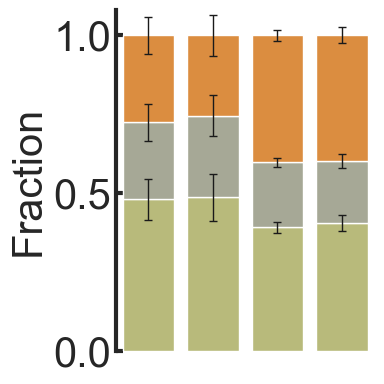

In [12]:
fig = plt.figure(figsize=(4, 4))
x = [1, 2, 3, 4]
colors = [
    "#B8BA7B",
    "#A6A896",
    "#DB8D40",
]

bottom = np.zeros(len(x))
categories = [
    "f1_mean",  # N=1
    "f2_mean",  # 1<N<=3
    "f3_mean",  # 3<N
]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]
plt.ylim(0, 1.08)
plt.ylabel("Fraction", size=30)
plt.xticks([])
plt.yticks([0, 0.5, 1])
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[["right", "top", "bottom"]].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=30,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.5
plt.xlim(1 - canvas_width, 4 + canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig(
    "Fracs_N_dwell_events-split_by_1_3-1x_1xdel_2x_2xdel.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)